In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
signal_length = 10000

omega = torch.fft.rfftfreq(signal_length) * signal_length

W1 = torch.randn([signal_length, signal_length]).to(device)
W2 = torch.randn([signal_length, signal_length]).to(device)
W3 = torch.randn([signal_length, signal_length + 2]).to(device)
b1 = torch.randn(signal_length).to(device)
b2 = torch.randn(signal_length).to(device)
b3 = torch.randn(signal_length + 2).to(device)

parameters = [W1, W2, W3, b1, b2, b3]

print("Parameter count:", sum(param.nelement() for param in parameters))

for param in parameters:
  param.requires_grad = True

Parameter count: 300050002


In [ ]:
import torchaudio

def load_audio_to_tensor(filepath, chunk_size):
    waveform, sample_rate = torchaudio.load(filepath)

    # Convert to mono by averaging the channels if it's not already mono
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # Normalize the waveform to the range [-1, 1]
    waveform = waveform / waveform.abs().max()

    waveform = waveform.view(-1)

    # Perform FFT
    fft_waveform = torch.fft.rfft(waveform)

    # Calculate frequency cutoff (Nyquist frequency)
    freq_cutoff = chunk_size // 2

    # Filter out frequencies higher than the cutoff
    filtered_fft_waveform = fft_waveform.clone()
    filtered_fft_waveform[freq_cutoff:] = 0

    # Perform inverse FFT
    filtered_waveform = torch.fft.irfft(filtered_fft_waveform, n=waveform.size(0))

    # Calculate the number of chunks
    num_chunks = len(filtered_waveform) // chunk_size

    # Split the waveform into chunks of size chunk_size
    chunks = filtered_waveform[:num_chunks*chunk_size].view(-1, chunk_size)

    normalized_chunks = (chunks - chunks.mean()) / chunks.std()  # Normalize

    # Plotting
    t = torch.linspace(0, waveform.size(0) / sample_rate, waveform.size(0))
    filtered_t = torch.linspace(0, filtered_waveform.size(0) / sample_rate, filtered_waveform.size(0))

    fig, axs = plt.subplots(2, 1, figsize=(12, 8))

    axs[0].plot(t.numpy(), waveform.numpy())
    axs[0].set_title('Original Waveform')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Amplitude')

    axs[1].plot(filtered_t.numpy(), filtered_waveform.numpy())
    axs[1].set_title('Filtered Waveform')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

    return normalized_chunks

def combine_fft_matrix(y):
  real, imag = torch.split(y, int(signal_length/2 + 1))
  transform = real + 1j * imag

  return transform
filepath = "/content/song.mp3"
X = load_audio_to_tensor(filepath, signal_length).to(device)

transforms = torch.fft.rfft(X, dim=1)

Y = torch.hstack((transforms.real, transforms.imag))
Y = ((Y- Y.mean()) / Y.std()).to(device)  # Normalize
print(X.shape, Y.shape)

idx =  320

plt.plot(X[idx].cpu())
plt.show()

plt.plot(omega, combine_fft_matrix(Y[idx].abs().cpu()))
plt.show()


ModuleNotFoundError: No module named 'torchaudio'

In [ ]:
# Training loop

def mse_loss(signals, transforms):
  mse = []
  for data, target in zip(signals, transforms):
    error = torch.mean((data - target)**2)
    mse.append(error.unsqueeze(0))  # Adds a new dimension, making it a 1D tensor

  mse = torch.cat(mse)  # Concatenates all error tensors along the new dimension
  return mse.mean()


epochs = 3000

lr = 1

lossi = []
stepi = []

nl = torch.nn.Sigmoid()

for i in range (epochs):
  ix = torch.randint(0, X.shape[0], (100,))

  layer1 = nl(X[ix] @ W1 + b1)
  layer2 = nl(layer1 @ W2 + b2)
  out = layer2 @ W3 + b3

  loss = mse_loss(Y[ix], out).to(device)

  if i % 50 == 0:
    print(f"Epoch: {i}, MSE: {loss.item()}")

  stepi.append(i)
  lossi.append(loss.item())

  for param in parameters:
    param.grad = None

  loss.backward()

  if loss.item() < 0.3:
    break

  lr = 0.1 if i < 1000 else 0.001

  for param in parameters:
    param.data += -lr * param.grad

print(f"Final MSE: {loss.item()}")


Epoch: 0, MSE: 496.5524597167969
Epoch: 50, MSE: 16.17715072631836
Epoch: 100, MSE: 8.20443344116211
Epoch: 150, MSE: 5.672843933105469
Epoch: 200, MSE: 4.680951118469238
Epoch: 250, MSE: 4.873430252075195
Epoch: 300, MSE: 2.3856663703918457
Epoch: 350, MSE: 1.7150259017944336
Epoch: 400, MSE: 2.114152431488037
Epoch: 450, MSE: 1.464447259902954
Epoch: 500, MSE: 1.6930184364318848
Epoch: 550, MSE: 3.100864887237549
Epoch: 600, MSE: 2.3476927280426025
Epoch: 650, MSE: 1.3411922454833984
Epoch: 700, MSE: 1.6407644748687744
Epoch: 750, MSE: 2.060870885848999
Epoch: 800, MSE: 1.7611078023910522
Epoch: 850, MSE: 1.4925594329833984
Epoch: 900, MSE: 0.507798969745636
Epoch: 950, MSE: 0.7523922324180603
Epoch: 1000, MSE: 1.3224194049835205
Epoch: 1050, MSE: 0.7853497266769409
Epoch: 1100, MSE: 0.5784406065940857
Epoch: 1150, MSE: 1.0402467250823975
Epoch: 1200, MSE: 1.0137498378753662
Epoch: 1250, MSE: 0.452295184135437
Epoch: 1300, MSE: 0.7938748598098755
Epoch: 1350, MSE: 1.34700345993042
Ep

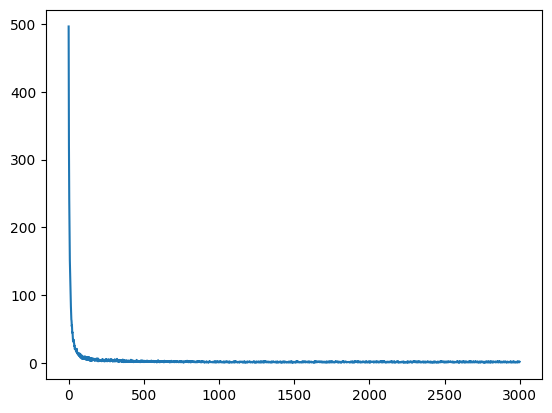

In [ ]:
plt.plot(stepi, lossi)

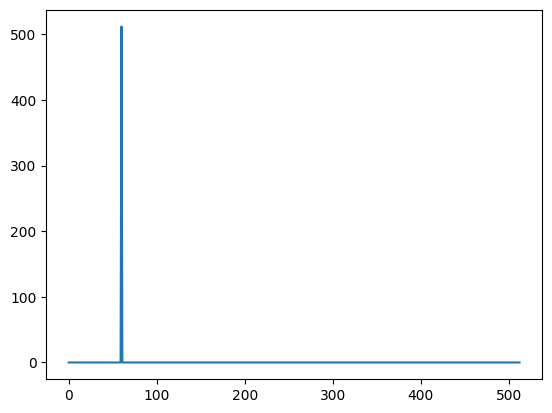

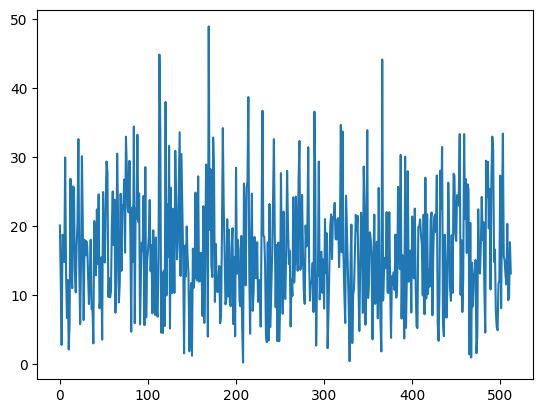

In [ ]:
from scipy.signal import boxcar

def nn_fft(x):
  x = torch.tensor(x, dtype=torch.float32).to(device)
  layer1 = nl(x @ W1 + b1)
  layer2 = nl(layer1 @ W2 + b2)
  out = layer2 @ W3 + b3
  real, imag = torch.split(out, int(signal_length/2 + 1))
  transform = real + 1j * imag

  return transform

frequency = 60  # frequency of the sine wave

# Generate the time vector
t = np.linspace(0, 1, signal_length, endpoint=False)  # 1 second duration

# Generate the sine wave
sin_wave = np.sin(2 * np.pi * frequency * t)

transform = torch.fft.rfft(torch.tensor(sin_wave)).to(device)
transform_nn = nn_fft(sin_wave).to(device)

mse_loss(transform, transform_nn).abs()

plt.plot(omega.cpu(), transform.abs().cpu())
plt.show()

plt.plot(omega.cpu(), transform_nn.abs().detach().cpu())
plt.show()